In [1]:
import tarfile
import warnings
from glob import glob

import anndata
import matplotlib.pyplot as plt
import muon as mu
import pandas as pd
import scanpy as sc
import scirpy as ir

sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [2]:
# set working directory 
import os
os.chdir("/hpc/group/goldsteinlab/vmd13/Python/250131_TCR_data")

In [3]:
mdata = mu.read_h5mu("/hpc/group/goldsteinlab/sk733/adata_gex_tcr_onlytcrsequenced_scVI.h5mu")

/hpc/group/goldsteinlab/envs/py3_11/lib/python3.11/site-packages/anndata/utils.py:349: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)
/hpc/group/goldsteinlab/envs/py3_11/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/hpc/group/goldsteinlab/envs/py3_11/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) t

In [4]:
import pandas as pd

# 1) Define your renaming dictionaries for "cond":
rename_cond_dict = {
    "normosmic": "Normosmic",
    "hyposmic":  "Hyposmic",
    # Adjust keys if your data has different spelling/case
}

# 2) Define the order you want for "cond":
cond_order = ["Normosmic", "Hyposmic"]

# 3) Define your renaming dictionary for patients:
rename_patients_dict = {
    "H2024_7":  "Normosmic 1",
    "H2024_14": "Normosmic 2",
    "H2024_28": "Normosmic 3",
    "H2024_2":  "Hyposmic 1",
    "H2024_5":  "Hyposmic 2",
    "H2024_29": "Hyposmic 3",
    # Add or adjust entries to match your dataset
}

# 4) Define the order you want for patients:
desired_patients_order = [
    "Normosmic 1", "Normosmic 2", "Normosmic 3",
    "Hyposmic 1", "Hyposmic 2", "Hyposmic 3"
]

# 5) Loop over both "airr" and "gex" layers, applying the same logic:
for prefix in ["airr", "gex"]:
    # A) Rename conditions
    mdata.obs[f"{prefix}:cond"] = mdata.obs[f"{prefix}:cond"].replace(rename_cond_dict)
    
    # B) Convert to ordered categorical
    mdata.obs[f"{prefix}:cond"] = pd.Categorical(
        mdata.obs[f"{prefix}:cond"],
        categories=cond_order,
        ordered=True
    )
    
    # C) Rename patients
    mdata.obs[f"{prefix}:orig_patients"] = (
        mdata.obs[f"{prefix}:orig_patients"].replace(rename_patients_dict)
    )
    
    # D) Convert patients to ordered categorical
    mdata.obs[f"{prefix}:orig_patients"] = pd.Categorical(
        mdata.obs[f"{prefix}:orig_patients"],
        categories=desired_patients_order,
        ordered=True
    )


/tmp/ipykernel_2458357/2630540266.py:33: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  mdata.obs[f"{prefix}:cond"] = mdata.obs[f"{prefix}:cond"].replace(rename_cond_dict)
/tmp/ipykernel_2458357/2630540266.py:44: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  mdata.obs[f"{prefix}:orig_patients"].replace(rename_patients_dict)


In [6]:
#adata.write("adata_gex_only_from_onlytcrsequenced_scVI.h5ad")

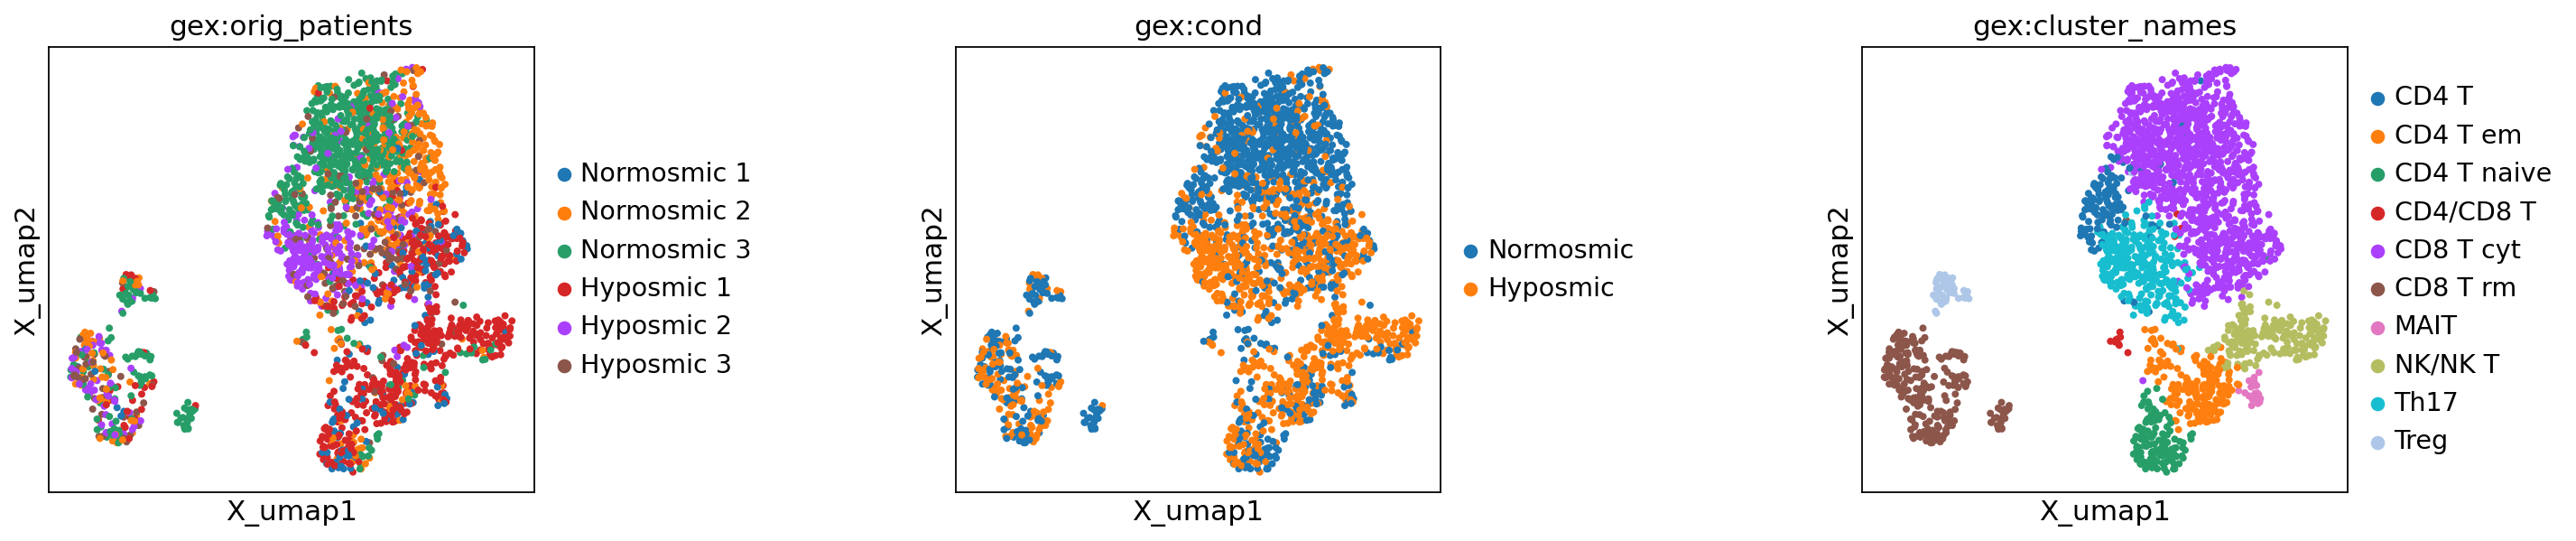

In [5]:
mu.pl.embedding(
    mdata,
    basis="gex:X_umap",
    color=["gex:orig_patients", "gex:cond", "gex:cluster_names"],
    ncols=3,
    wspace=0.7,
)


In [6]:
ir.pp.index_chains(mdata)

Filtering chains...
Indexing VJ chains...
Indexing VDJ chains...
build result array


In [7]:
ir.tl.chain_qc(mdata)

Stored result in `mdata.obs["airr:receptor_type"]`.
Stored result in `mdata.obs["airr:receptor_subtype"]`.
Stored result in `mdata.obs["airr:chain_pairing"]`.


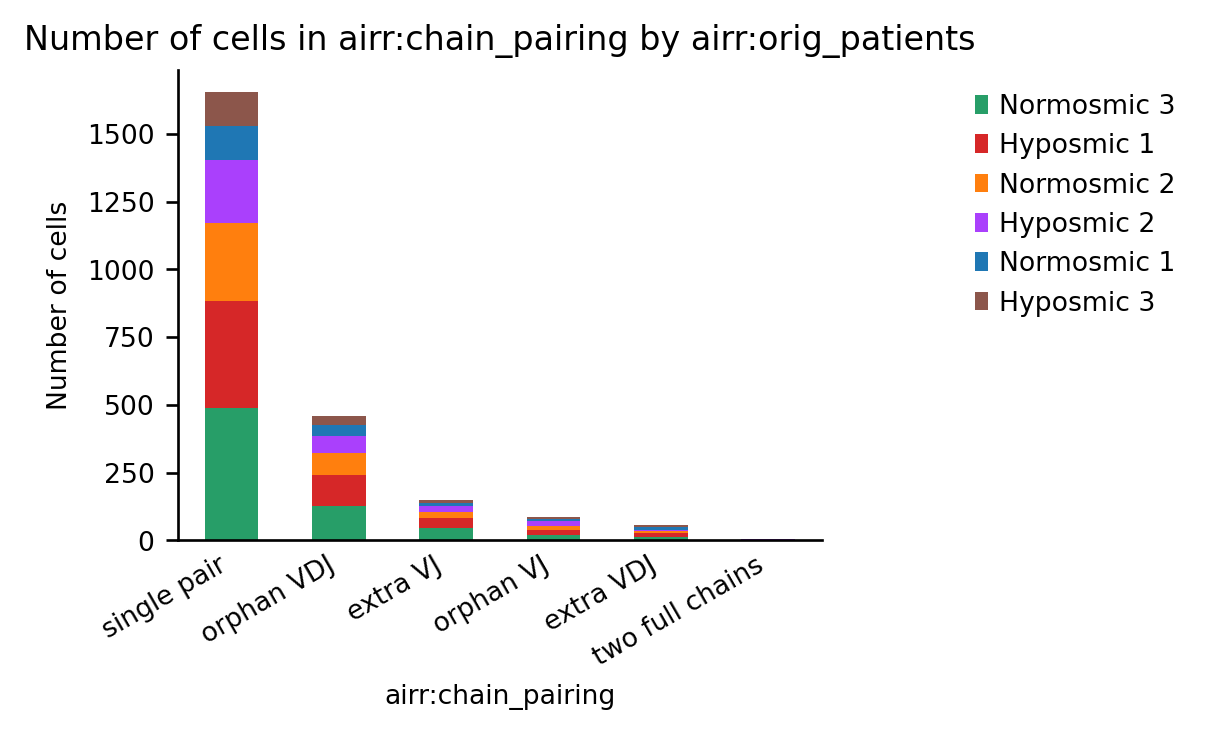

In [8]:
ax = ir.pl.group_abundance(
    mdata,
    groupby="airr:chain_pairing",
    target_col="airr:orig_patients",
)

# Grab the figure from the axes
fig = ax.figure

# Save the figure as an SVG
fig.savefig("sup_chainpairing_by_orig_patients.svg", bbox_inches="tight")


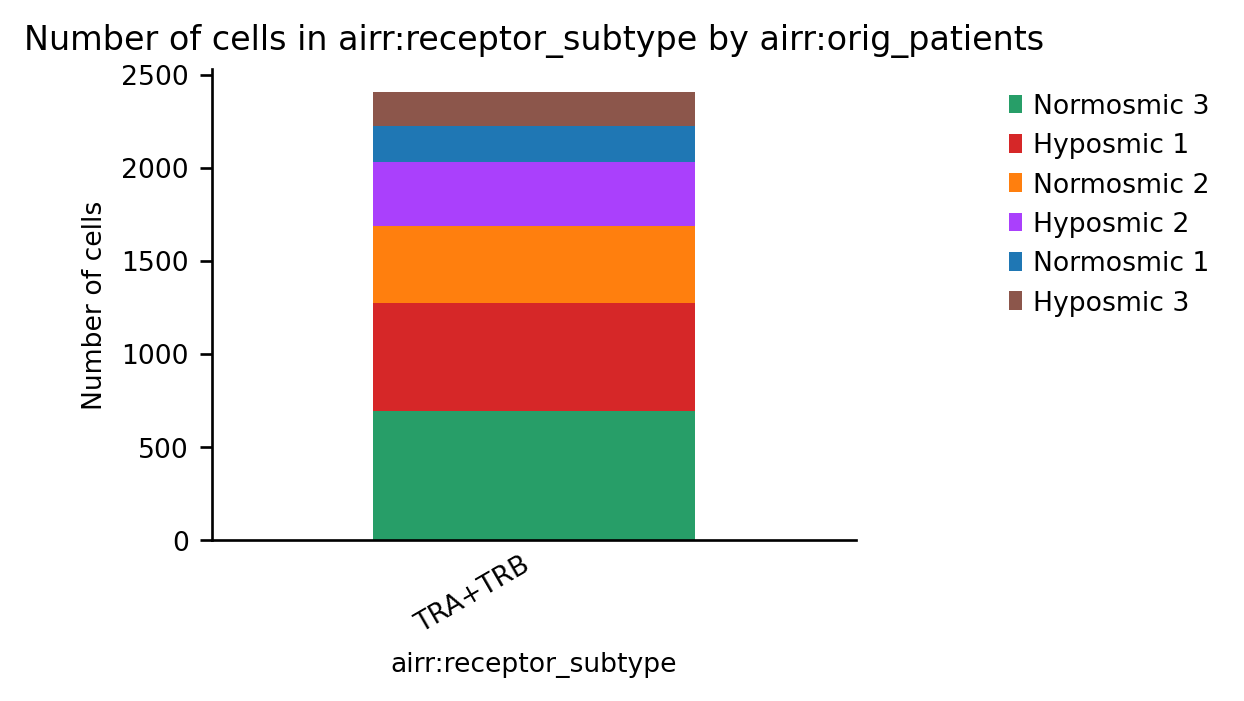

In [9]:
_ = ir.pl.group_abundance(mdata, groupby="airr:receptor_subtype", target_col="airr:orig_patients")

In [10]:
import numpy as np
print(
    "Fraction of cells with more than one pair of TCRs: {:.2f}".format(
        np.sum(mdata.obs["airr:chain_pairing"].isin(["extra VJ", "extra VDJ", "two full chains", "multichain"]))
        / mdata["airr"].n_obs
    )
)

Fraction of cells with more than one pair of TCRs: 0.09


In [11]:
mu.pp.filter_obs(mdata, "airr:chain_pairing", lambda x: x != "multichain")

In [12]:
mu.pp.filter_obs(mdata, "airr:chain_pairing", lambda x: ~np.isin(x, ["orphan VDJ", "orphan VJ"]))

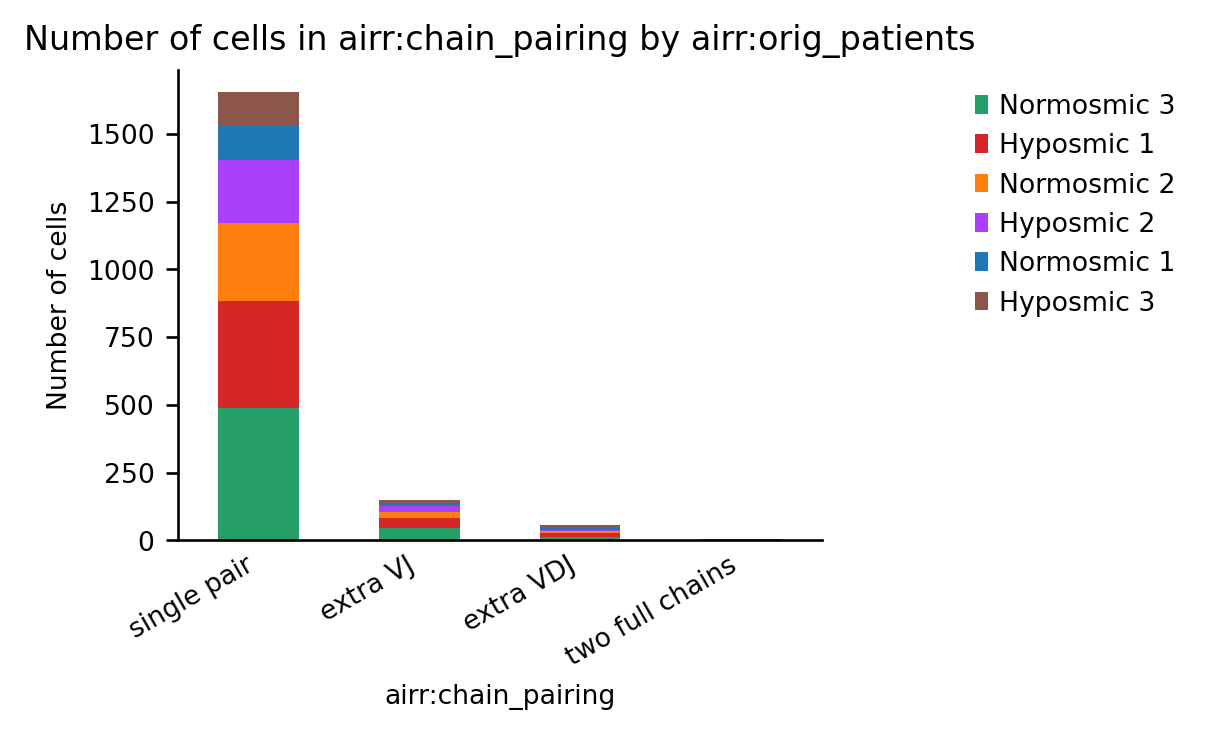

In [13]:
ax = ir.pl.group_abundance(mdata, groupby="airr:chain_pairing", target_col="airr:orig_patients")

# Grab the figure from the axes
fig = ax.figure

# Save the figure as an SVG
#fig.savefig("sup_chainpairing_by_orig_patients_after_qc.svg", bbox_inches="tight")


In [14]:
# using default parameters, `ir_dist` will compute nucleotide sequence identity
ir.pp.ir_dist(mdata)
ir.tl.define_clonotypes(mdata, receptor_arms="all", dual_ir="primary_only")

Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.
Initializing lookup tables. 
Computing clonotype x clonotype distances.
Stored result in `mdata.obs["airr:clone_id"]`.
Stored result in `mdata.obs["airr:clone_id_size"]`.


In [15]:
ir.tl.clonal_expansion(mdata)

Stored result in `mdata.obs["airr:clonal_expansion"]`.


In [16]:
mdata

MuData object with n_obs × n_vars = 1863 × 23412
  2 modalities
    gex:	1808 x 23412
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'orig_patients', 'total_counts_mito', 'pct_counts_mito', '_scvi_batch', '_scvi_labels', 'leiden_scVI_Alz', 'cond', 'cluster_names'
      var:	'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean_', 'frac_zero'
      uns:	'_scvi_manager_uuid', '_scvi_uuid', 'cluster_names_colors', 'hvg', 'leiden', 'leiden_scVI_Alz_colors', 'neighbors', 'umap', 'gex:orig_patients_colors', 'gex:cond_colors', 'gex:cluster_names_colors'
      obsm:	'X_scVI_Alz', 'X_umap', '_scvi_extra_continuous_covs'
      varm:	'df_poisson'
      layers:	'counts', 'norm'
      obsp:	'connectivities', 'distances'
    airr:	1863 x 0
      obs:	'orig_patients', 'cond', 'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size', 'clonal_expansion'
      uns:	'chain_indices', 'ir_dist_nt_identity', 'clone_id'
      obsm:	'airr', 'chain_indices'

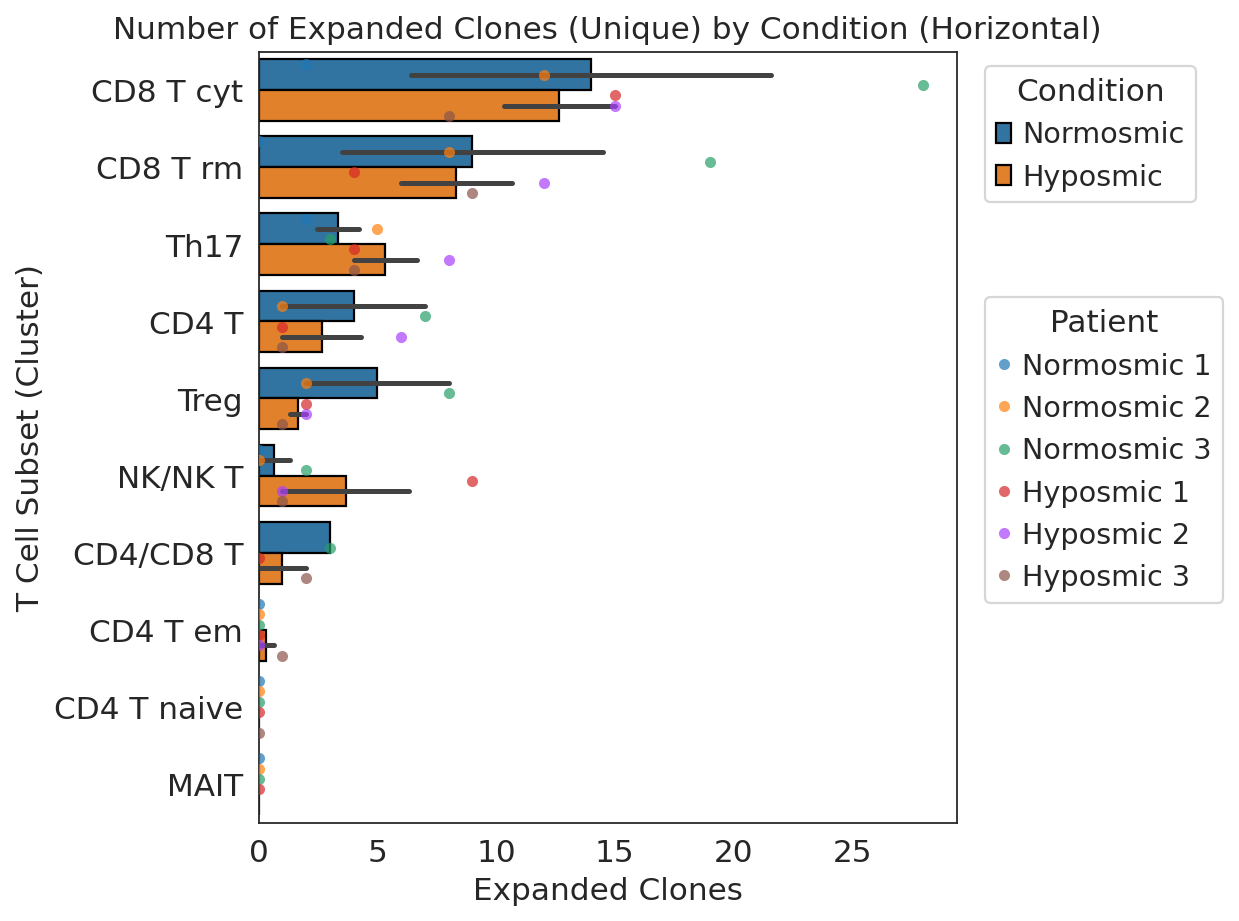

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------------
# 1) PREPARE YOUR DATA
# ------------------------------------------------------
df = mdata.obs.copy()

# Mark each cell/clone as "is_expanded" if airr:clonal_expansion == "> 2"
df["is_expanded"] = df["airr:clonal_expansion"].eq("> 2")

# ------------------------------------------------------
# 2) GROUP TO IDENTIFY UNIQUE CLONES & WHETHER THEY'RE EXPANDED
# ------------------------------------------------------
grouped = (
    df.groupby(
        ["gex:cluster_names", "airr:orig_patients", "airr:cond", "airr:clone_id"],
        observed=True  # Adopting the future default
    )
    .agg(is_expanded=("is_expanded", "any"))  # True if ANY cell in that clone_id is expanded
    .reset_index()
)

# ------------------------------------------------------
# 3) COUNT HOW MANY UNIQUE CLONES ARE EXPANDED PER (SUBSET, PATIENT, CONDITION)
# ------------------------------------------------------
clone_counts = (
    grouped.groupby(
        ["gex:cluster_names", "airr:orig_patients", "airr:cond"],
        observed=True
    )["is_expanded"]
    .agg(
        expanded_clones="sum",   # number of distinct expanded clones
        total_clones="count"
    )
    .reset_index()
)

# (Optional) proportion of expanded clones
clone_counts["proportion_expanded_clones"] = (
    clone_counts["expanded_clones"] / clone_counts["total_clones"]
)

# ------------------------------------------------------
# 4) ORDER SUBSETS BY THE MEAN # OF EXPANDED CLONES, DESCENDING
# ------------------------------------------------------
# NOTE: add observed=True here as well, to suppress future warnings
cluster_means = (
    clone_counts.groupby("gex:cluster_names", observed=True)["expanded_clones"]
    .mean()
    .sort_values(ascending=False)
)
cluster_order = cluster_means.index.tolist()

# ------------------------------------------------------
# 5) CREATE THE HORIZONTAL BARPLOT + STRIPPLOT
# ------------------------------------------------------
sns.set_style("white")
plt.figure(figsize=(8, 6))

# Use the new 'errorbar' parameter in Seaborn >= 0.12 for SEM
# Instead of 'ci="se"', use 'errorbar="se"'
ax = sns.barplot(
    data=clone_counts,
    y="gex:cluster_names",
    x="expanded_clones",
    hue="airr:cond",
    errorbar="se",     # <--- Standard error of the mean
    edgecolor="black",
    order=cluster_order,
    orient="h"
)

sns.stripplot(
    data=clone_counts,
    y="gex:cluster_names",
    x="expanded_clones",
    hue="airr:orig_patients",
    order=cluster_order,
    orient="h",
    dodge=True,
    alpha=0.7,
    size=5,
    ax=ax
)

plt.title("Number of Expanded Clones (Unique) by Condition (Horizontal)")
plt.xlabel("Expanded Clones")
plt.ylabel("T Cell Subset (Cluster)")
plt.xlim(left=0)  # Clip the x-axis at zero

# ------------------------------------------------------
# 6) MANAGE LEGENDS
# ------------------------------------------------------
handles, labels = ax.get_legend_handles_labels()
ax.legend_.remove()

n_cond = clone_counts["airr:cond"].nunique()

cond_handles = handles[:n_cond]
cond_labels  = labels[:n_cond]
patient_handles = handles[n_cond:]
patient_labels  = labels[n_cond:]

# Legend for condition
l1 = plt.legend(
    cond_handles, cond_labels,
    title="Condition",
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)
ax.add_artist(l1)

# Legend for patients
plt.legend(
    patient_handles, patient_labels,
    title="Patient",
    bbox_to_anchor=(1.02, 0.7),
    loc="upper left"
)

plt.tight_layout()
plt.savefig("250305_expanded_clones_horizontal.svg", format="svg", bbox_inches="tight")
plt.show()


/tmp/ipykernel_2458357/1991053749.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts.groupby("gex:cluster_names")["cell_count"]


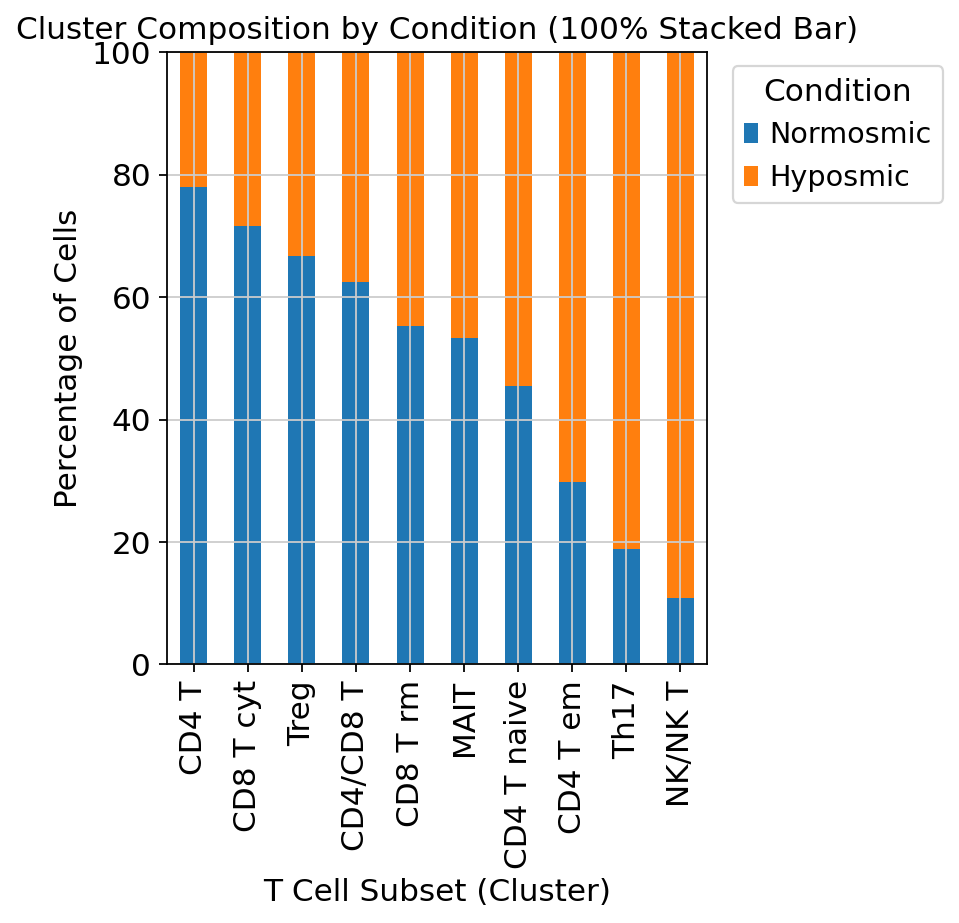

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Count cells in each (cluster, condition)
counts = (
    mdata.obs
    .groupby(["gex:cluster_names", "gex:cond"], observed=True)
    .size()
    .reset_index(name="cell_count")
)

# 2) Convert to percentages within each cluster
counts["pct"] = (
    counts.groupby("gex:cluster_names")["cell_count"]
    .transform(lambda x: 100 * x / x.sum())
)

# 3) Pivot: rows = cluster, columns = condition, values = percentages
pivoted = counts.pivot(
    index="gex:cluster_names",
    columns="gex:cond",
    values="pct"
)

# 4) Sort by the fraction of (for example) "Hyposmic" in descending order
#    If your condition is named differently, substitute it here.
if "Normosmic" in pivoted.columns:
    pivoted = pivoted.loc[
        pivoted["Normosmic"].sort_values(ascending=False).index
    ]
else:
    # If you have some other target condition or just the largest column:
    # pivoted = pivoted.loc[pivoted.sum(axis=1).sort_values(ascending=False).index]
    pass

# 5) Plot a 100% stacked bar (descending order left-to-right)
ax = pivoted.plot(
    kind="bar",
    stacked=True,
    figsize=(6, 6)
)

ax.set_xlabel("T Cell Subset (Cluster)")
ax.set_ylabel("Percentage of Cells")
ax.set_ylim(0, 100)
ax.set_title("Cluster Composition by Condition (100% Stacked Bar)")

plt.legend(title="Condition", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.savefig("cluster_composition.svg", format="svg", bbox_inches="tight") #
plt.show()


In [18]:
counts = (
    mdata.obs
    .groupby(["gex:cluster_names", "gex:cond"], observed=True)
    .size()
    .reset_index(name="cell_count")
)


In [19]:
import pandas as pd

crosstab = pd.crosstab(
    counts["gex:cluster_names"],
    counts["gex:cond"],
    values=counts["cell_count"],
    aggfunc="sum"
).fillna(0)

crosstab


gex:cond,Normosmic,Hyposmic
gex:cluster_names,,
CD4 T,64,18
CD4 T em,44,104
CD4 T naive,41,49
CD4/CD8 T,5,3
CD8 T cyt,613,243
CD8 T rm,106,86
MAIT,8,7
NK/NK T,16,131
Th17,44,190


In [20]:
import numpy as np
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

clusters = crosstab.index.tolist()
conditions = crosstab.columns.tolist()

# We assume the two conditions are ["Normosmic", "Hyposmic"]
# If they are in a different order or have more conditions,
# you can subset them accordingly.
cond1 = "Normosmic"
cond2 = "Hyposmic"

# total counts for each condition
cond1_total = crosstab[cond1].sum()
cond2_total = crosstab[cond2].sum()

pvals = []
for cluster in clusters:
    # a = # cells of this cluster in cond1
    a = crosstab.loc[cluster, cond1]
    # b = # cells of this cluster in cond2
    b = crosstab.loc[cluster, cond2]
    # c = # cells of other clusters in cond1
    c = cond1_total - a
    # d = # cells of other clusters in cond2
    d = cond2_total - b

    # 2x2 contingency table
    contingency_table = np.array([[a, b],
                                  [c, d]])
    
    # Fisher's exact test (two-sided)
    _, p = fisher_exact(contingency_table, alternative='two-sided')
    pvals.append(p)

# Multiple-testing correction
reject, pvals_corrected, _, _ = multipletests(pvals, method='fdr_bh')
results = pd.DataFrame({
    'Cluster': clusters,
    'p_value': pvals,
    'p_value_fdr': pvals_corrected,
    'reject_H0': reject
}).sort_values('p_value')

results


,Cluster,p_value,p_value_fdr,reject_H0
4,CD8 T cyt,4.187614e-50,4.187614e-49,True
8,Th17,3.559060e-31,1.779530e-30,True
7,NK/NK T,1.828821e-29,6.096070e-29,True
1,CD4 T em,1.663734e-09,4.159335e-09,True
0,CD4 T,3.815070e-06,7.630140e-06,True
9,Treg,1.288209e-01,1.866181e-01,False
2,CD4 T naive,1.306327e-01,1.866181e-01,False
5,CD8 T rm,6.462803e-01,8.078504e-01,False
3,CD4/CD8 T,7.309293e-01,8.121437e-01,False
6,MAIT,1.000000e+00,1.000000e+00,False
